# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [5]:
data_dir = Path('./open')

val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./ensemble/build/sub')

dirs = [val_dir, tst_dir, sub_dir]
for d in dirs:
    os.makedirs(d, exist_ok=True)

trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'mta'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [7]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author,length
index,,,
0,He was almost choking. There was so much so mu...,3,235
1,Your sister asked for it I suppose,2,34
2,She was engaged one day as she walked in peru...,1,312
3,The captain was in the porch keeping himself c...,4,305
4,Have mercy gentlemen odin flung up his hands. ...,3,215


In [8]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


## Preprocessing

`MultiHeadSelfAttention` and `TransformerBlock` from the [Text classification with Transformer](https://keras.io/examples/nlp/text_classification_with_transformer/) tutorial at the Keras website.

In [9]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [11]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [12]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,index,author,length
count,181013.0000,181013.0000,181013.0000
mean,91514.5870,2.0491,164.5379
std,53025.4182,1.2863,178.6952
min,0.0000,0.0000,20.0000
25%,45490.0000,1.0000,65.0000
50%,91441.0000,2.0000,113.0000
75%,137458.0000,3.0000,189.0000
max,183467.0000,4.0000,2454.0000


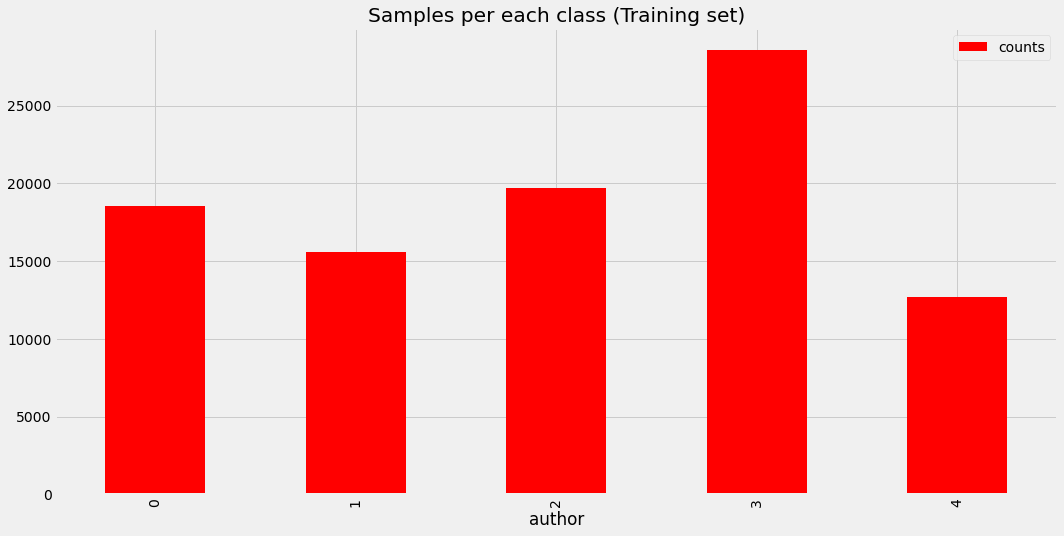

In [13]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [14]:

df = df.reset_index()
df['index'] = df['index'].reset_index()

In [15]:
train = df
train= train.drop(columns=['level_0'])
train

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,235
1,1,sister asked suppose,2,34
2,2,engaged one day walked perusing janes last let...,1,312
3,3,captain porch keeping carefully way treacherou...,4,305
4,4,mercy gentlemen odin flung hands dont write an...,3,215
...,...,...,...,...
95080,95080,diningroom soon joined odin odin busily engage...,1,150
95081,95081,one came books toilette,1,56
95082,95082,faces however tolerably calm no change visible...,1,252
95083,95083,still ticking hall,2,29


In [16]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(95085,) (19617,) (95085,)


In [17]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(95085,) (19617,) (95085,)


## Training

In [18]:
vocab_size = 20000
maxlen = 250
embed_dim = 64
num_heads = 4  # Number of attention heads
padding_type='post'

In [19]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [20]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [21]:
trn = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
tst = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)
print(trn.shape, tst.shape)

(95085, 250) (19617, 250)


In [22]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [23]:
def get_model():
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(n_class, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.001))
    return model

In [24]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=128,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold
    
    clear_session()
    gc.collect()    

training model for CV #1
Epoch 1/10
595/595 [==============================] - 36s 60ms/step - loss: 1.2238 - val_loss: 0.8238
Epoch 2/10
595/595 [==============================] - 35s 59ms/step - loss: 0.7059 - val_loss: 0.7393
Epoch 3/10
595/595 [==============================] - 35s 59ms/step - loss: 0.5306 - val_loss: 0.7917
Epoch 4/10
595/595 [==============================] - 35s 59ms/step - loss: 0.4264 - val_loss: 0.8694
Epoch 5/10
595/595 [==============================] - 35s 58ms/step - loss: 0.3589 - val_loss: 1.0555
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
595/595 [==============================] - 36s 61ms/step - loss: 1.1640 - val_loss: 0.8267
Epoch 2/10
595/595 [==============================] - 35s 59ms/step - loss: 0.6920 - val_loss: 0.7416
Epoch 3/10
595/595 [==============================] - 35s 58ms/step - loss: 0.5273 - val_loss: 0.8601
Epoch 4/10
595/595 [==============================] - 35s 59ms/step - loss: 0.4306 - val_loss: 0.9191
Epoc

In [25]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  72.2617%
Log Loss (CV):   0.7505


In [26]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [27]:
print(clf.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 250, 64)      1296000     input_1[0][0]                    
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 250, 64)      21088       token_and_position_embedding[0][0
                                                                 transformer_block[0][0]          
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 64)           0           transformer_block[1][0

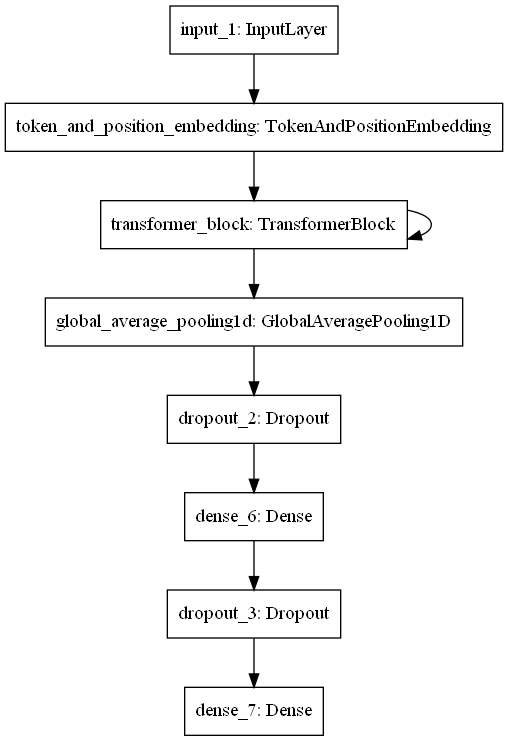

In [28]:
plot_model(clf)

## 제출 파일 생성

In [29]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [30]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0192,0.1773,0.7185,0.0756,0.0095
1,0.1207,0.5434,0.0260,0.0425,0.2674
2,0.9308,0.0576,0.0025,0.0006,0.0085
3,0.0241,0.0039,0.9220,0.0079,0.0421
4,0.4787,0.0793,0.0332,0.3425,0.0663


In [31]:
sub.to_csv(sub_file)